# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

This notebook is code along of by a Youtube tutorial by Rob Mulla.


### Understanding GBoosting(AdaBoost), XGBoosting, FB Prophet and LightGBM for time series forecasting

In [52]:

"""
References:
A great thread why Boosting for Regression problem rather than RNN,LSTM, GRU etc.- https://www.reddit.com/r/learnmachinelearning/comments/101ay0o/xgboost_and_neural_networks/
Forecasting with trees - https://www.sciencedirect.com/science/article/pii/S0169207021001679
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
https://www.nvidia.com/en-us/glossary/xgboost/
https://developer.nvidia.com/blog/gradient-boosting-decision-trees-xgboost-cuda/
https://www.youtube.com/watch?v=vV12dGe_Fho
https://www.youtube.com/watch?v=j0eioK5edqg&list=RDCMUCxladMszXan-jfgzyeIMyvw&index=5
https://developer.nvidia.com/blog/goai-open-gpu-accelerated-data-analytics/
Implementation - https://developer.nvidia.com/blog/gradient-boosting-decision-trees-xgboost-cuda/
"""

'\nReferences:\nA great thread why Boosting for Regression problem rather than RNN,LSTM, GRU etc.- https://www.reddit.com/r/learnmachinelearning/comments/101ay0o/xgboost_and_neural_networks/\nForecasting with trees - https://www.sciencedirect.com/science/article/pii/S0169207021001679\nhttps://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/\nhttps://www.nvidia.com/en-us/glossary/xgboost/\nhttps://developer.nvidia.com/blog/gradient-boosting-decision-trees-xgboost-cuda/\nhttps://www.youtube.com/watch?v=vV12dGe_Fho\nhttps://www.youtube.com/watch?v=j0eioK5edqg&list=RDCMUCxladMszXan-jfgzyeIMyvw&index=5\nhttps://developer.nvidia.com/blog/goai-open-gpu-accelerated-data-analytics/\nImplementation - https://developer.nvidia.com/blog/gradient-boosting-decision-trees-xgboost-cuda/\n'

In [53]:
#Conclusion: Time series in their pure state are not very common in the real world. Meaning a series of numbers without any context. 
#As soon as you have any context you are mostly dealing with tabular data where xgboost is still the king.
#Random forest “bagging” minimizes the variance and overfitting, while GBDT “boosting” minimizes the bias and underfitting.

'''XGBoost is a scalable and highly accurate implementation of gradient boosting that pushes the limits of computing power 
for boosted tree algorithms, being built largely for energizing machine learning model performance and computational speed. 
With XGBoost, trees are built in parallel, instead of sequentially like GBDT. It follows a level-wise strategy, scanning across 
gradient values and using these partial sums to evaluate the quality of splits at every possible split in the training set. '''

'XGBoost is a scalable and highly accurate implementation of gradient boosting that pushes the limits of computing power \nfor boosted tree algorithms, being built largely for energizing machine learning model performance and computational speed. \nWith XGBoost, trees are built in parallel, instead of sequentially like GBDT. It follows a level-wise strategy, scanning across \ngradient values and using these partial sums to evaluate the quality of splits at every possible split in the training set. '

In [54]:
#It depends on the architecture. There are types of neural networks that outperform decision trees on (some) tabular data, 
#e.g.: https://arxiv.org/abs/1806.06988, https://arxiv.org/abs/1909.06312, https://arxiv.org/abs/2206.00664. 
#But finding the right architecture and hyper-parameters for your task is a dark art.

"""
Neural networks require tons of data, and benefit a lot from (semi-)supervised pre-training. 
Neural network can learn amazing feature representations from raw data, but if you only have a sample size of 500, 
trees on top of handcrafted features will probably work much better.
"""

'\nNeural networks require tons of data, and benefit a lot from (semi-)supervised pre-training. \nNeural network can learn amazing feature representations from raw data, but if you only have a sample size of 500, \ntrees on top of handcrafted features will probably work much better.\n'

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb # download xgoost if not aready there 
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [56]:
df = pd.read_csv('hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

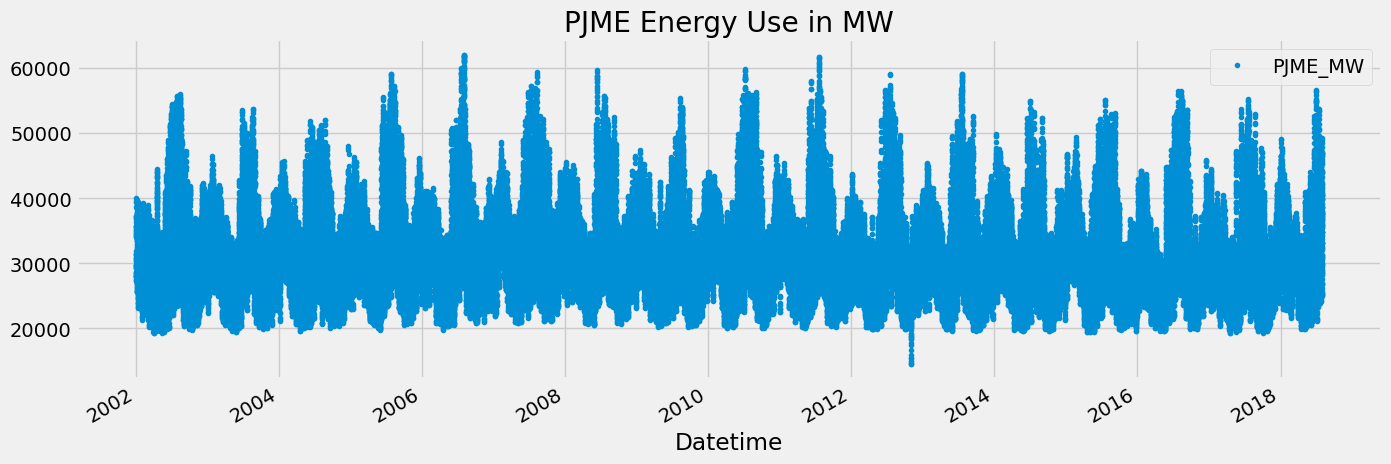

In [57]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

# Important - Split data as per date so as we don't mix up past and future informations

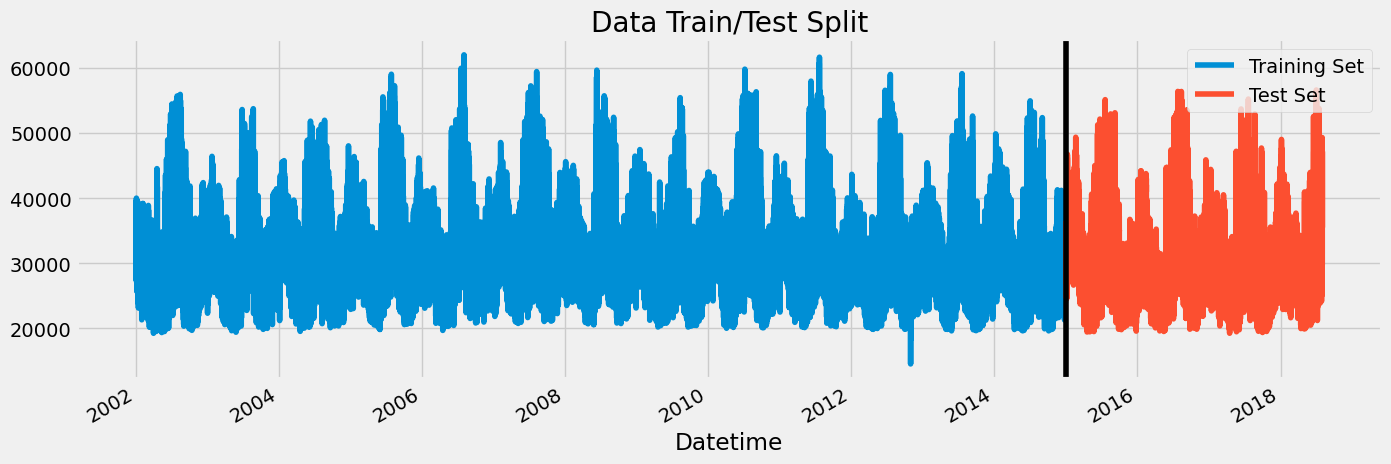

In [58]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='-')
ax.legend(['Training Set', 'Test Set'])
plt.show()

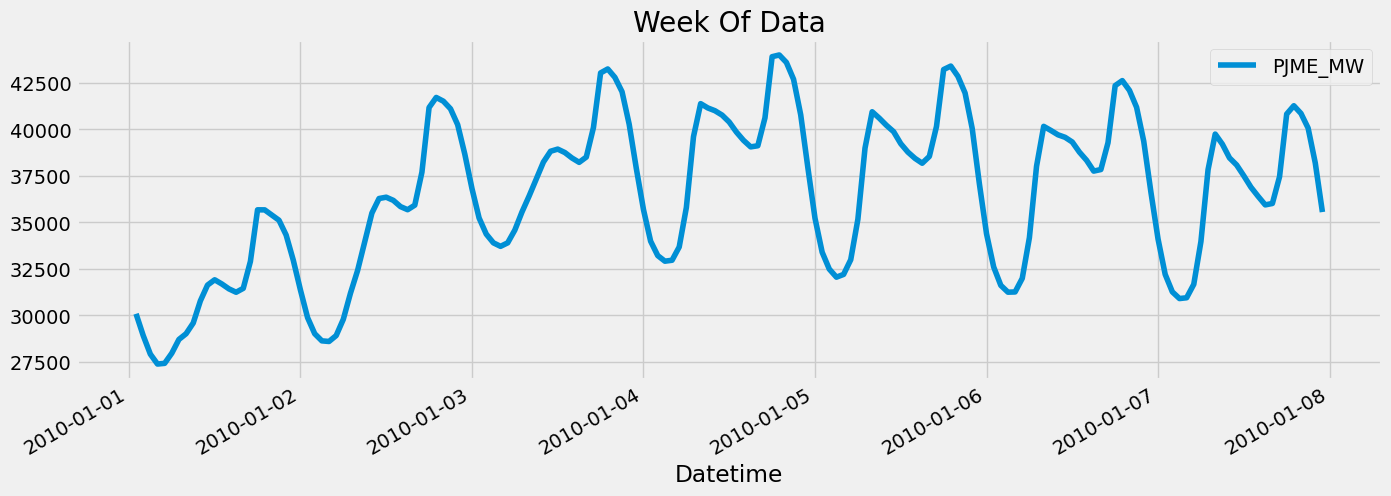

In [59]:
#Trying to figure out if there is a trend over the week which seems like a possibility as weekend affect can be seen
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [60]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy() # to create a copy of the df so that we do not change the actual df
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week # important pandas methods to use calender
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


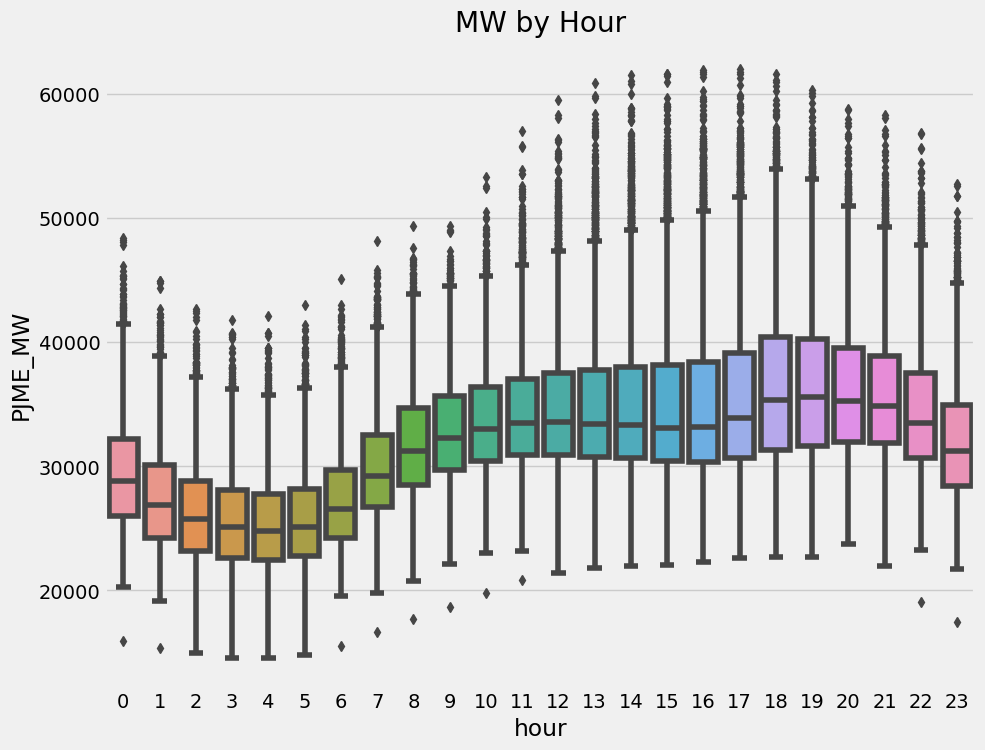

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

#Conclusion: Nights use more power than days 

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


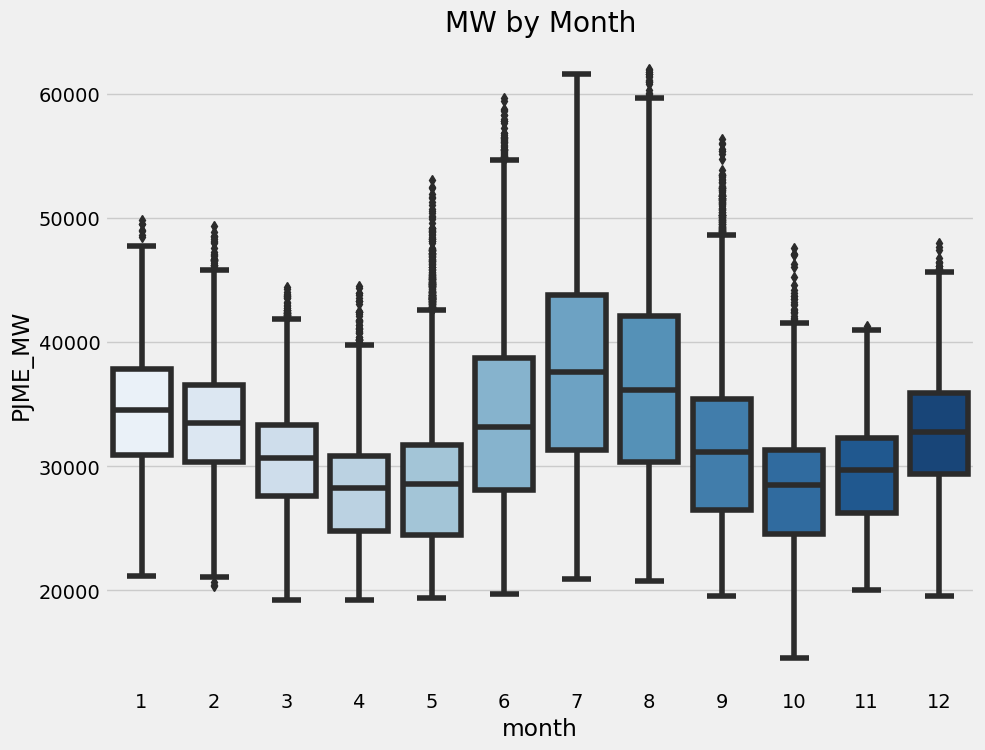

In [62]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()
#Conclusion: Consumptions in summers and winters is high 

# Create our Model

In [63]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [64]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

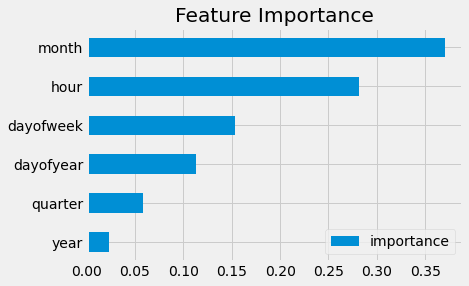

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

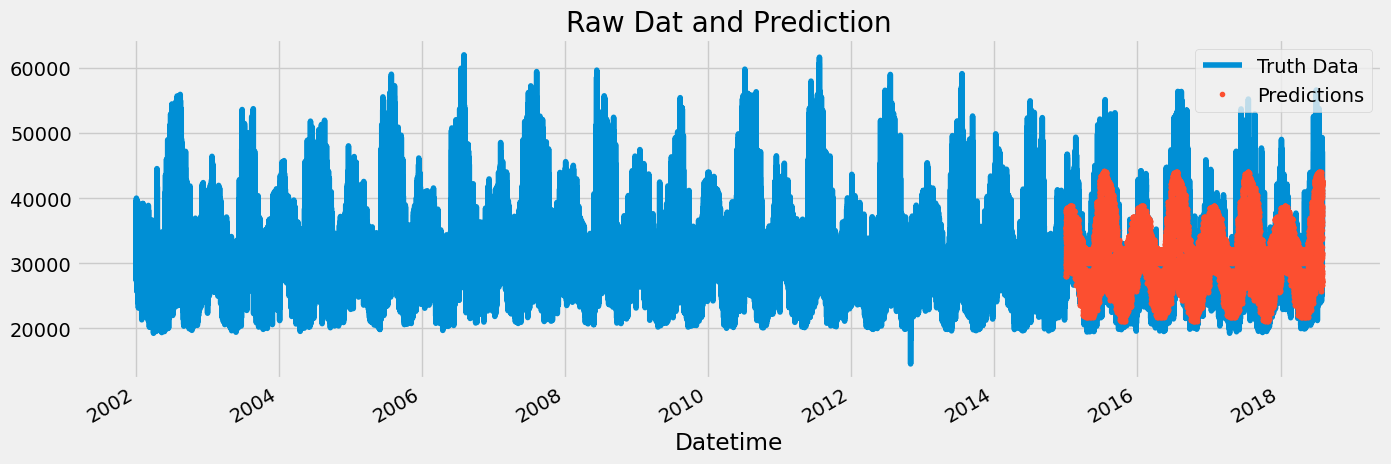

In [68]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

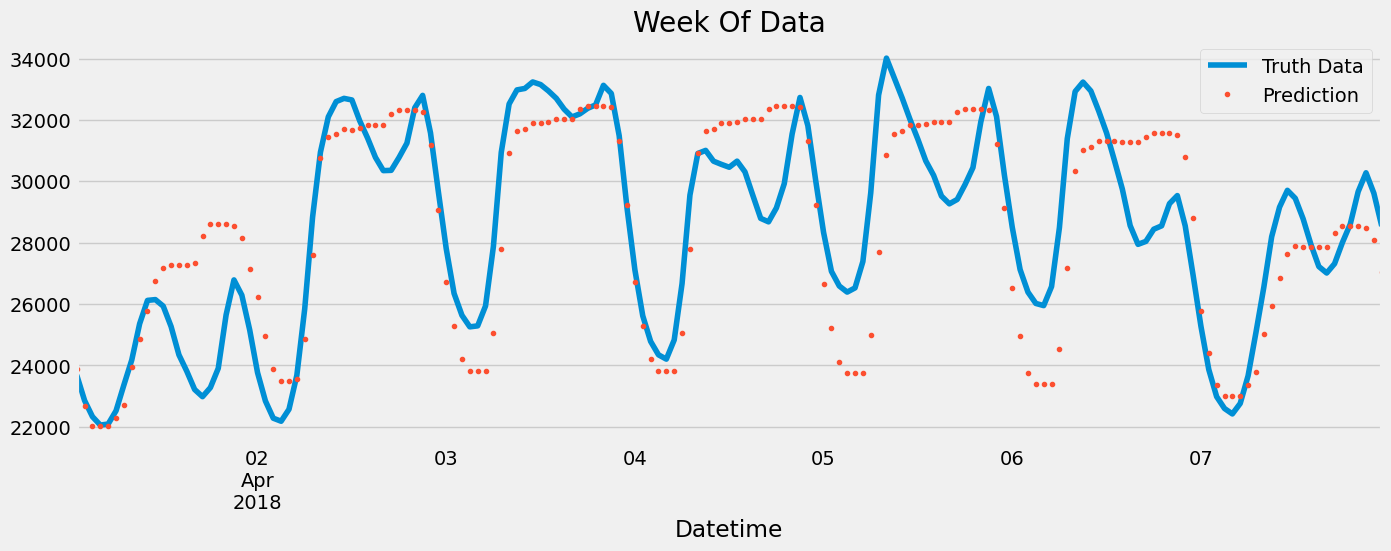

In [69]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [70]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


# Calculate Error
- Look at the worst and best predicted days

In [71]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

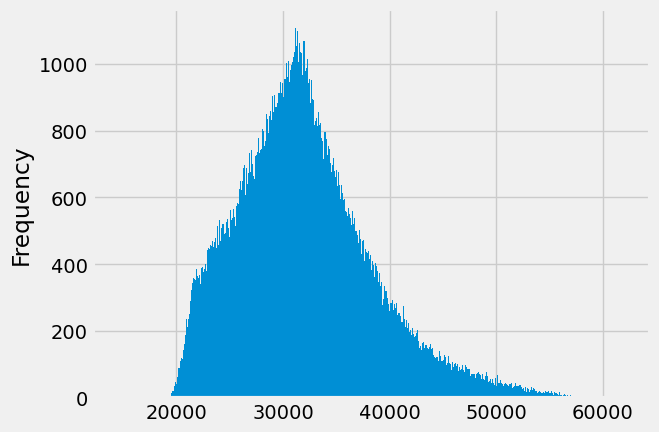

In [73]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

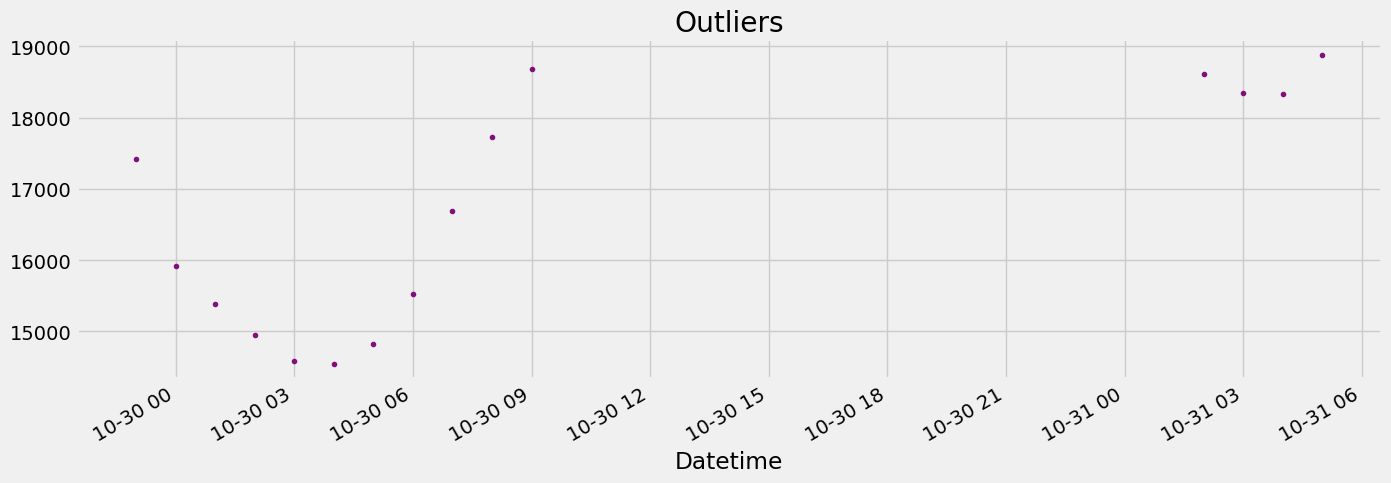

In [74]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [75]:
df = df.query('PJME_MW > 19_000').copy()

# 1. Time Series Cross Validation

In [76]:
#sklearn time series splits

In [77]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

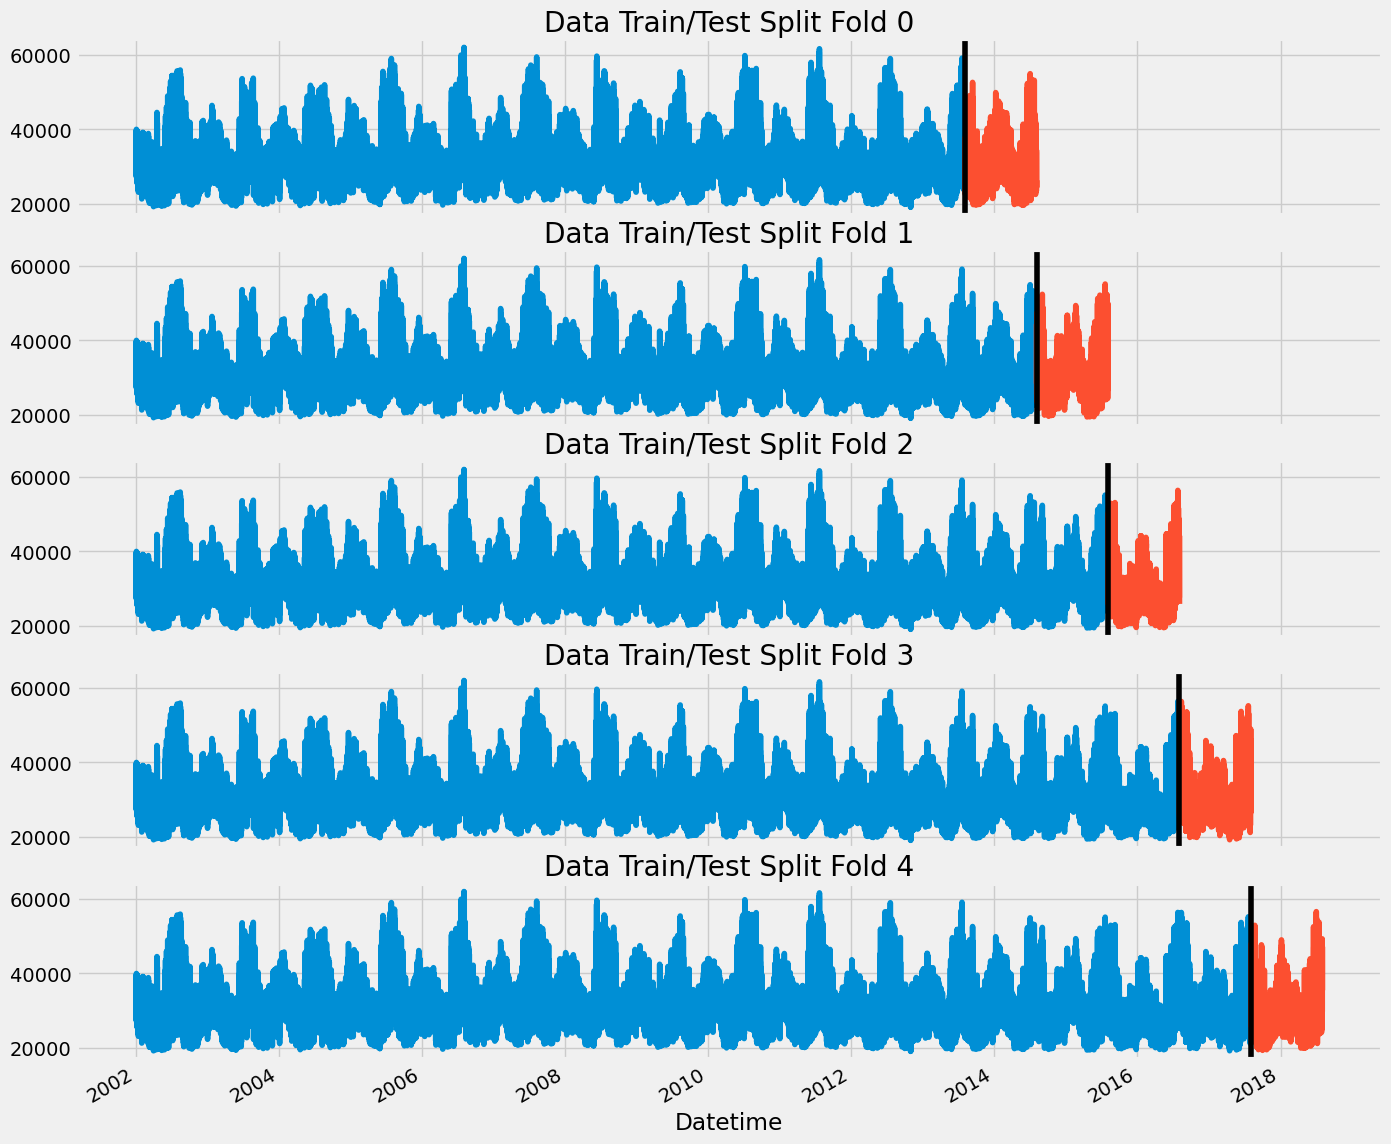

In [79]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='-')
    fold += 1
plt.show()

# 2. Forecasting Horizon
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [81]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [86]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 not 365 as it gives out exact days back of the week due to divisibvility by 7
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) #728 divisible by 7
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [87]:
df = add_lags(df)

In [88]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN


In [89]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42575.265625,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42522.703125,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40804.101562,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,37933.539062,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,31588.259766,33539.0,32094.0,31695.0


In [96]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782
[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[445]	validation_0-rmse:3365.94502	validation_1-rmse:3757.55814
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459
[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[500]	validation_0-rmse:3352.66618	validation_1-rmse:3523.07822
[600]	validation_0-rmse:3296.70510	validation_1-rmse:3487.82916
[700]	validation_0-rmse:3257.73321	validation_1-rmse:3468.06020
[800]	validation_0-rmse:3222.25681	validation_1-rmse:3445.37604
[900]	validation_0-rmse:3192.52469	validation_1-rmse:3432.72311
[999]	validation_0-rmse:3165.63907	validation_1-rmse:3425.71868
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575
[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408	validation_1-rmse:3542.09733
[400]	validation_0-rmse:3492.92067	validation_1-rmse:3488.41143
[402]	validation_0-rmse:3489.21578	validation_1-rmse:3490.11888
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.18076	validation_1-rmse:12018.20453
[200]	validation_0-rmse:5737.83720	validation_1-rmse:5794.21490
[300]	validation_0-rmse:3914.73269	validation_1-rmse:4385.31167
[400]	validation_0-rmse:3497.45006	validation_1-rmse:4169.33613
[500]	validation_0-rmse:3382.37925	validation_1-rmse:4114.28118
[600]	validation_0-rmse:3323.85812	validation_1-rmse:4100.91700
[700]	validation_0-rmse:3282.58032	validation_1-rmse:4088.30188
[770]	validation_0-rmse:3258.81926	validation_1-rmse:4084.53074
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.41304	validation_1-rmse:11962.08478
[200]	validation_0-rmse:5751.81541	validation_1-rmse:5613.52924
[300]	validation_0-rmse:3951.49944	validation_1-rmse:4150.62570
[400]	validation_0-rmse:3540.50262	validation_1-rmse:4001.62992
[439]	validation_0-rmse:3482.16787	validation_1-rmse:4003.54837


In [97]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3746.8788
Fold scores:[3753.6176552727843, 3425.271376428151, 3473.313333085868, 4083.6723271785127, 3998.5195052083054]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [98]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.50092


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.52175
[400]	validation_0-rmse:3572.64777
[499]	validation_0-rmse:3458.28412


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [99]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [100]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [102]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,NaN,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,NaN,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,NaN,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,NaN,40666.0,34555.0,34641.0,True


## Predict the future

In [105]:
future_w_features = df_and_future.query('isFuture').copy()

In [106]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

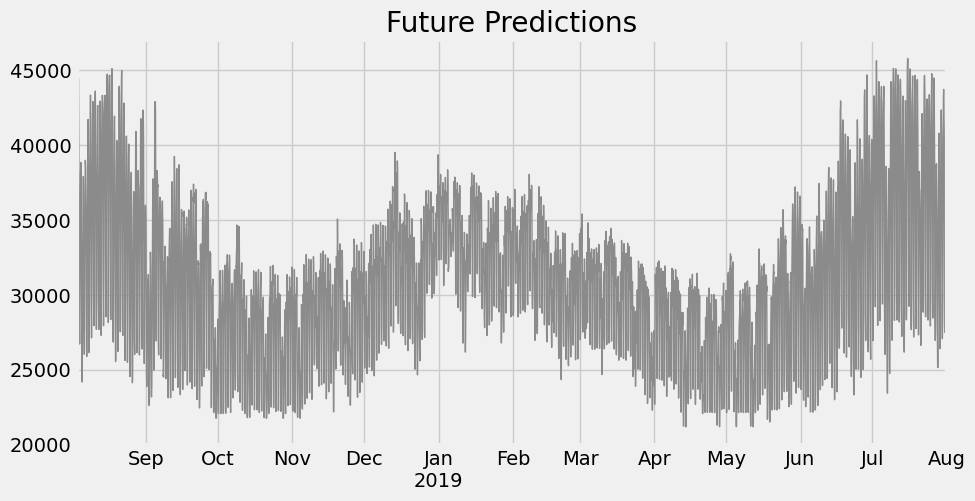

In [107]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [108]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

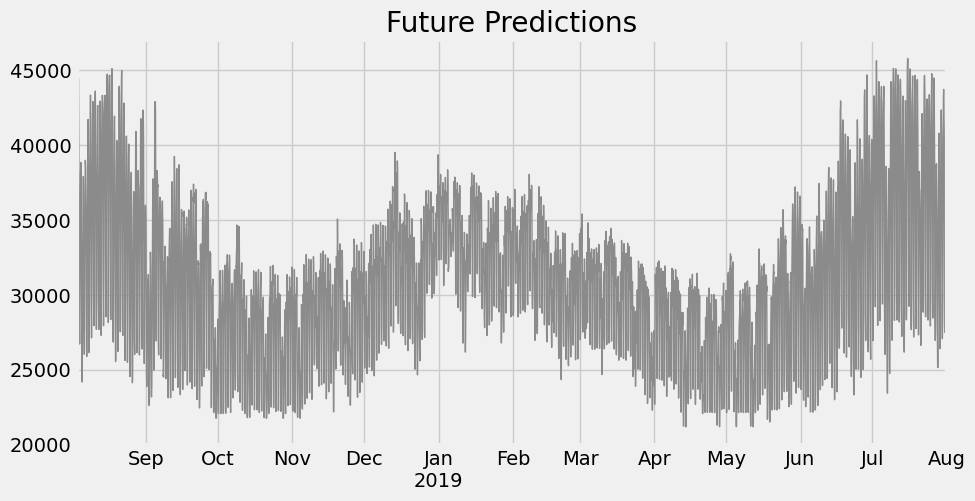

In [111]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')